In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [2]:
df = pd.read_csv('bigdata.txt', header=None)

In [3]:
df.values

array([[  44.003316,  167.93424 ],
       [  49.409332,  181.17085 ],
       [  46.469245,  173.13197 ],
       [  49.400011,  180.45534 ],
       [  46.053899,  172.53482 ],
       [  44.235629,  167.98254 ],
       [  51.994983,  186.15658 ],
       [  41.867176,  162.97074 ]])

# Maximum Likelihood Solution

We know that the maximum likelihood solution for this case $w_{ML}$ (obtained by maximizing the log-likelihood function) is equivalent to the least-squares solution $w*$ discussed in Homework 01 (obtained by minimizing the least-squares function). Then, we obtain the solution by solving $(X^TX)^{-1}X^TY$

In [4]:
def ml_solution(X, t):
    xxt = np.dot(np.transpose(X), X)
    inv = np.linalg.inv(xxt)
    X_factor = np.dot(inv, np.transpose(X))
    return np.dot(X_factor, t)

In [5]:
X = np.zeros((len(df.values),2))
X[:, 0] = 1.
X[:, 1] = df[0].values
t = df[1].values

X, t

(array([[  1.      ,  44.003316],
        [  1.      ,  49.409332],
        [  1.      ,  46.469245],
        [  1.      ,  49.400011],
        [  1.      ,  46.053899],
        [  1.      ,  44.235629],
        [  1.      ,  51.994983],
        [  1.      ,  41.867176]]),
 array([ 167.93424,  181.17085,  173.13197,  180.45534,  172.53482,
         167.98254,  186.15658,  162.97074]))

In [6]:
wml = ml_solution(X, t)
wml

array([ 64.7815874 ,   2.34066887])

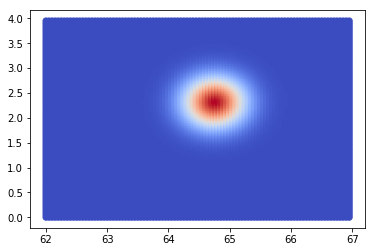

In [19]:
def predict(x, w):
    return w[0] + w[1]*x

def mse(X, t, w):
    s = sum([(predict(x, w) - y)**2 for x,y in zip(X,t)])/len(X)
    return s
    
cov_ml = np.eye(2)*mse(df[0].values, df[1].values, wml)

x = np.array([(x,y) for x in np.arange(62, 67, 0.05) for y in np.arange(0, 4, 0.05)])
dist = stats.multivariate_normal.pdf(x, mean=wml, cov=cov_ml)

plt.scatter([p[0] for p in x], [p[1] for p in x], c=dist, cmap=mpl.cm.coolwarm)

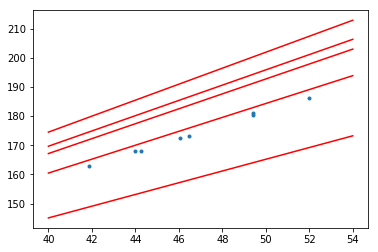

In [20]:
samples = []
for _ in range(5):
    samples.append(stats.multivariate_normal.rvs(mean=wml, cov=cov_ml))

plt.plot(df[0].values, df[1].values, '.')
pos = [x for x in range(40, 55)]
pos
for sample in samples:
    plt.plot(pos, [sample[0] + sample[1]*x for x in pos], 'r')

# Batch Bayesian Estimate

To make it bayesian, we must introduce a prior distribution over the parameters of the distribution. Our prior will be a gaussian $N(m_0, \alpha^{-1} I)$. We will use $m_0 = (m, n)^T$ where $m = \frac{t_1 - t_8}{x_1 - x_8}$ and $n = t_0 - mx_0$. 

As for the precision, we will use$\alpha^{-1} = \frac{1}{N} \sum\limits_{k=1}^{N} (p(x_k) - t_k)^2$, where $p(x) = mx + n$. The posterior distribution is

0.14104130640591189

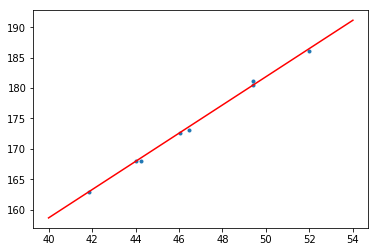

In [22]:
m = (df[1][0] - df[1][7])/(df[0][0] - df[0][7])
n = df[1][0] - m*df[0][0]

plt.plot(df[0].values, df[1].values, '.')
plt.plot(pos, [n + m*x for x in pos], 'r')

cov = mse(df[0].values, df[1].values, np.array([n, m]))